#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
data_train = pd.read_csv(path + '/data01_train.csv')
data_test = pd.read_csv(path + '/data01_test.csv')


In [ ]:
data_train= data_train.drop('subject', axis=1)
data_test= data_test.drop('subject', axis=1)

#### 2) 기본 정보 조회

In [ ]:
data_train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING


In [ ]:
data_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
data_train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
data_train['is_dynamic'] = data_train['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
x_binary = data_train.drop(['Activity','is_dynamic'], axis=1)
y_binary = data_train['is_dynamic']

data_test['is_dynamic'] = data_test['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})

In [ ]:
data_train_static = data_train.loc[
    (data_train['Activity'] == 'STANDING') |
    (data_train['Activity'] == 'SITTING') |
    (data_train['Activity'] == 'LAYING')
]

data_train_dynamic = data_train.loc[
    (data_train['Activity'] == 'WALKING') |
    (data_train['Activity'] == 'WALKING_UPSTAIRS') |
    (data_train['Activity'] == 'WALKING_DOWNSTAIRS')
]

data_test_static = data_test.loc[
    (data_test['Activity'] == 'STANDING') |
    (data_test['Activity'] == 'SITTING') |
    (data_test['Activity'] == 'LAYING')
]

data_test_dynamic = data_test.loc[
    (data_test['Activity'] == 'WALKING') |
    (data_test['Activity'] == 'WALKING_UPSTAIRS') |
    (data_test['Activity'] == 'WALKING_DOWNSTAIRS')
]

data_train_dynamic['Activity'].value_counts()

,count
Activity,
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


### (2) x, y 분리

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


In [ ]:
LabelEncoder = LabelEncoder()
y = LabelEncoder.fit_transform(y)

In [ ]:
LableEncoder.classes_

### (4) 데이터 분할
* train, val 분할

In [ ]:
scaler = MinMaxScaler()
x_binary = scaler.fit_transform(x_binary)


In [ ]:
x_binary_train, x_binary_val, y_binary_train, y_binary_val = train_test_split(x_binary, y_binary, test_size=0.2, random_state=1)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [ ]:
clear_session()
model5 = Sequential([Input(shape=(x_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(6, activation='sigmoid')])
model5.summary()

In [ ]:
model5.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy')


In [ ]:
model5.fit(x_train, y_train, validation_data=(x_val, y_val),verbose=0, epochs=100)

In [ ]:
joblib.dump(model5, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model5_binary_v2.pkl')

In [ ]:
y_pred = model5.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [ ]:
dl_history_plot(model5.history.history)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

#### 2) 모델2

In [ ]:
clear_session()
model3 = Sequential([Input(shape=(x_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                    #
                    Dense(6, activation='softmax')])
model3.summary()

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')

In [ ]:
history3 = model3.fit(x_train, y_train, validation_split=0.2, verbose =0,epochs=100).history

In [ ]:
y_pred = model3.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [ ]:
joblib.dump(model3, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model3_binary_v2.pkl')

In [ ]:
dl_history_plot(history3)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

## (3) 모델 로드

In [ ]:
model_binary = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model5_binary.pkl')


In [ ]:
y_pred_binary = model_binary.predict(x_binary_val)
y_pred_binary = np.where(y_pred_binary > 0.5, 1, 0)
print(confusion_matrix(y_binary_val, y_pred_binary))
print(classification_report(y_binary_val, y_pred_binary))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[653   2]
 [  0 522]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data_train_static.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [ ]:
x_train_static = data_train_static.drop('Activity', axis=1)
y_train_static = data_train_static['Activity']

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


In [ ]:
scaler = MinMaxScaler()
x_train_static = scaler.fit_transform(x_train_static)


In [ ]:
LabelEncoder = LabelEncoder()
y_train_static = LabelEncoder.fit_transform(y_train_static)

In [ ]:
print(LabelEncoder.classes_)

['LAYING' 'SITTING' 'STANDING']


In [ ]:
print(y_train_static)
print(y_train_dynamic)

[2 0 2 ... 1 0 1]
[0 1 2 ... 0 2 2]


In [ ]:
x_s_train, x_s_val, y_s_train, y_s_val = train_test_split(x_train_static, y_train_static, test_size=0.2, random_state=1)

In [ ]:
clear_session()
model_static = Sequential([Input(shape=(x_s_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(3, activation='softmax')])
model_static.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,195 (2.01 MB)

 Trainable params: 528,195 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_static.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')
history_static = model_static.fit(x_s_train, y_s_train, validation_data=(x_s_val, y_s_val),verbose=0, epochs=100).history

In [ ]:
y_pred = model_static.predict(x_s_val)
y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_s_val, y_pred))
print(classification_report(y_s_val, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[204   0   0]
 [  1 213   6]
 [  0  20 203]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.91      0.97      0.94       220
           2       0.97      0.91      0.94       223

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647



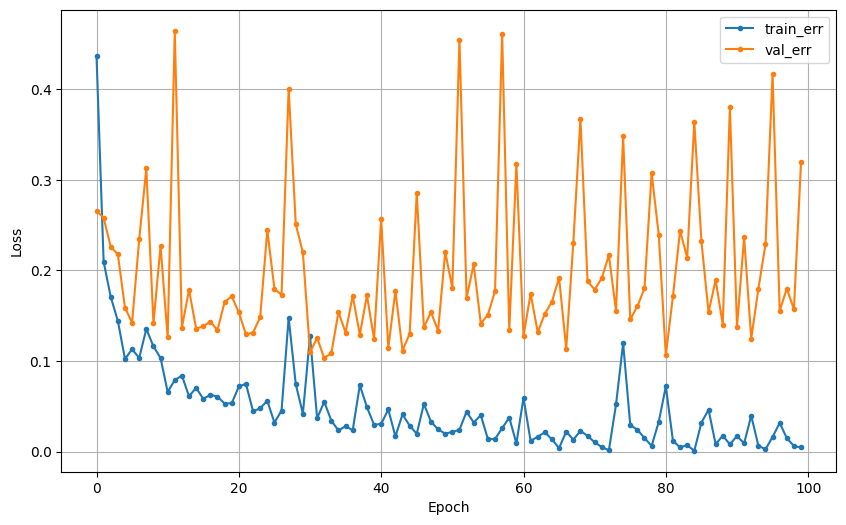

In [ ]:
dl_history_plot(history_static)

In [ ]:
joblib.dump(model_static, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model_static.pkl')

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model_static.pkl']

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
x_train_dynamic = data_train_dynamic.drop('Activity', axis=1)
y_train_dynamic = data_train_dynamic['Activity']

In [ ]:
scaler = MinMaxScaler()
x_train_dynamic = scaler.fit_transform(x_train_dynamic)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

LabelEncoder = LabelEncoder()
y_train_dynamic = LabelEncoder.fit_transform(y_train_dynamic)

In [ ]:
print(LabelEncoder.classes_)

['WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS']


In [ ]:

x_d_train, x_d_val, y_d_train, y_d_val = train_test_split(x_train_dynamic, y_train_dynamic, test_size=0.2, random_state=1)

In [ ]:
clear_session()
model_dynamic = Sequential([Input(shape=(x_d_train.shape[1],)),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(3, activation='softmax')])
model_dynamic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,195 (2.01 MB)

 Trainable params: 528,195 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model_dynamic.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy')
history_dynamic = model_dynamic.fit(x_d_train, y_d_train, validation_data=(x_d_val, y_d_val),verbose=0, epochs=100).history

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[214   0   0]
 [  0 163   0]
 [  0   0 153]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00       153

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



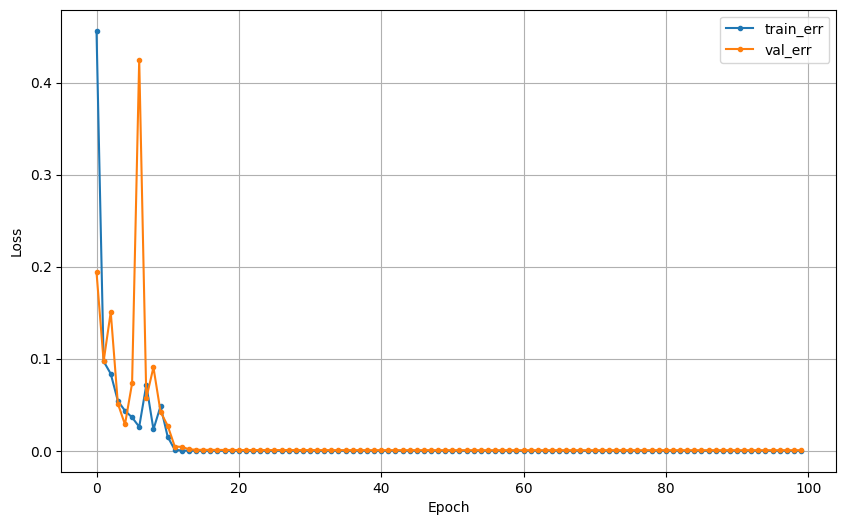

['/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model_dynamic.pkl']

In [ ]:


y_pred = model_dynamic.predict(x_d_val)
y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_d_val, y_pred))
print(classification_report(y_d_val, y_pred))
dl_history_plot(history_dynamic)
joblib.dump(model_dynamic, '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model_dynamic.pkl')

### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
data_train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity',
       'is_dynamic'],
      dtype='object', length=563)

In [ ]:
def model_pipleline(model_binary, model_static, model_dynamic, data_test):
  data_test= data_test.drop('subject', axis=1)

  data_test['is_dynamic'] = data_test['Activity'].map({'STANDING': 0, 'SITTING': 0, 'LAYING': 0, 'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1})
  x_binary = data_test.drop(['Activity', 'is_dynamic'], axis=1)
  y_binary = data_test['is_dynamic']
  y = data_test['Activity']

  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)
  print("Label encoder classes:", label_encoder.classes_)

  # 스케일러 적용
  scaler = MinMaxScaler()
  x_binary_scaled = scaler.fit_transform(x_binary)

  # 이진 예측
  binary_pred = model_binary.predict(x_binary_scaled)
  binary_pred = np.where(binary_pred > 0.5, 1, 0)

  # 정적 및 동적 예측을 위한 리스트
  static_pred_lists = np.where(binary_pred == 0)[0]
  dynamic_pred_lists = np.where(binary_pred == 1)[0]



  # 샘플 추출
  static_samples_x = x_binary_scaled[static_pred_lists]
  static_samples_y = y[static_pred_lists]
  dynamic_samples_x = x_binary_scaled[dynamic_pred_lists]
  dynamic_samples_y = y[dynamic_pred_lists]

  # Convert to float32 dtype if not already
  static_samples_x = static_samples_x.astype(np.float32)
  dynamic_samples_x = dynamic_samples_x.astype(np.float32)

  # static 모델 예측
  y_static_pred = model_static.predict(static_samples_x)
  y_static_pred = np.argmax(y_static_pred, axis=1)

  # dynamic 모델 예측
  y_dynamic_pred = model_dynamic.predict(dynamic_samples_x)
  y_dynamic_pred = np.argmax(y_dynamic_pred, axis=1)

  # 두 예측 결과 병합
  y_pred = np.concatenate((y_static_pred, y_dynamic_pred+3), axis=0)
  y_true = np.concatenate((static_samples_y, dynamic_samples_y), axis=0)

  # 결과 출력
  print("\nPrediction results:")
  print(y_pred)
  print("\nTrue labels:")
  print(y_true)
  print("\nConfusion Matrix:")
  print(confusion_matrix(y_true, y_pred))
  print("\nClassification Report:")
  print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

#### 2) test 셋으로 예측하고 평가하기

In [305]:
# 모델로드
model_binary = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model5_binary.pkl')
model_static = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model_static.pkl')
model_dynamic = joblib.load( '/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/models/model_dynamic.pkl')

In [ ]:
data_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS


In [306]:
data_test = pd.read_csv('/content/drive/MyDrive/kt/mini_project_3/2024.10.16_미니프로젝트 3차_실습자료/data01_test.csv')
model_pipleline(model_binary, model_static, model_dynamic, data_test)

Label encoder classes: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Prediction results:
[1 2 1 ... 4 4 4]

True labels:
[1 2 1 ... 4 4 4]

Confusion Matrix:
[[288   3   0   0   0   1]
 [  0 240  14   0   0   0]
 [  0   9 278   0   0   0]
 [  0   0   0 225   2   1]
 [  0   0   0   1 194   0]
 [  0   0   0   2   3 210]]

Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       292
           SITTING       0.95      0.94      0.95       254
          STANDING       0.95      0.97      0.96       287
           WALKING       0.99      0.99      0.99       228
WALKING_DOWNSTAIRS       0.97      0.99      0.98       195
  WALKING_UPSTAIRS       0.99      0.98      0.98       215

          accuracy                           0.98      1471
         macro avg